# Imports

In [1]:
!nvidia-smi

Fri Dec  2 23:04:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers --quiet
!pip install sentencepiece --quiet

     |████████████████████████████████| 5.8 MB 154 kB/s 
     |████████████████████████████████| 7.6 MB 66.9 MB/s 
     |████████████████████████████████| 182 kB 66.7 MB/s 
     |████████████████████████████████| 1.3 MB 4.8 MB/s 


In [3]:
import os
import sys
import time
import string
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, \
  LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from transformers import BertTokenizer, TFBertModel, AutoModel, AutoTokenizer
from transformers import BertConfig, BertTokenizer, TFBertModel
import transformers

## Global Variables and Google Drive Connect

In [4]:
TESTING = False # use to truncate training data in order to speed up development

RANDOM_STATE = 42
SEQUENCE_LENGTH = 512
BATCH_SIZE = 1
USER = 'Alex'
RUBRIC_COLS = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
PATIENCE = 2
LEARNING_RATE = 0.0001
LEARNING_RATE_DECAY = 0.1
EPOCHS = 4
# Uncomment these two lines if you want to be able to be able to repeat calculations exactly on the same hardware
# However, the model will run more slowly (approx 1/3 speed)
# tf.keras.utils.set_random_seed(RANDOM_STATE)
# tf.config.experimental.enable_op_determinism()

In [5]:
# Mount drive where you will do your work.
drive.mount('/content/drive')
if USER == 'Alex': 
  root_dir = "/content/drive/MyDrive/w266/"
  project_folder = "Final_Project/"
elif USER == 'Kurt':
  root_dir = "/content/drive/My Drive/266/"
  project_folder = "Final Project/"
elif USER == 'Tom':
  root_dir = "/content/drive/My Drive/UC Berkeley/W266 Natural Language Processing/"
  project_folder = "Final Project/"
else:
  raise Exception("User unrecognized, must connect to shared drive")

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  # to test if all is working, you can uncomment these two lines below--it should write a file to the shared drive
  # !touch 'new_file_in_working_directory.txt'
  # print('\nYour working directory was changed to ' + root_dir + project_folder + \
  #       "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

os.chdir(root_dir + project_folder)

Mounted at /content/drive


# Load Data and Create Data Sets

In [6]:
#Pull training data with all columns
X_train = pd.read_csv('data/processed/X_train.csv')
y_train = pd.read_csv('data/processed/y_train.csv')

#pull validation data with all columns 
X_val = pd.read_csv('data/processed/X_val.csv')
y_val = pd.read_csv('data/processed/y_val.csv')

# # #pull test data with all columns
X_test = pd.read_csv('data/processed/X_test.csv')
y_test = pd.read_csv('data/processed/y_test.csv')
test_data = pd.merge(X_test, y_test, on='essay_index', how='outer')

test_data = test_data[['full_text', 'cohesion', 'syntax', 'vocabulary_y', 'phraseology', 'grammar', 'conventions']]
test_data.rename(columns={'vocabulary_y':'vocabulary'}, inplace= True)

#drop all non-text columns and concatenate train and val into one dataset
train_data = pd.merge(X_train, y_train, on='essay_index', how='outer')
validation_data = pd.merge(X_val, y_val, on='essay_index', how='outer')

#create train set
train_data = train_data[['full_text','cohesion', 'syntax', 'vocabulary_y', 'phraseology', 'grammar', 'conventions']]
train_data.rename(columns={'vocabulary_y':'vocabulary'}, inplace= True)

#create val set
val_data = validation_data[['full_text','cohesion', 'syntax', 'vocabulary_y', 'phraseology', 'grammar', 'conventions']]
val_data.rename(columns={'vocabulary_y':'vocabulary'}, inplace= True)

print("train data size is: {}".format(train_data.shape))
print("test size is: {}".format(val_data.shape))

train data size is: (2347, 7)
test size is: (782, 7)


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [7]:
if TESTING:
  train_size = 250
  val_size = 3

  print("=========================================\nIN TESTING MODE\n=========================================")

else:
  train_size = 2347
  val_size = 782

train_data = train_data[:train_size]
val_data = val_data[:val_size]

print("input_data size is: {}".format(train_data.shape))
print("validation data size is: {}".format(val_data.shape))
print("Test data size is: {}".format(test_data.shape))

input_data size is: (2347, 7)
validation data size is: (782, 7)
Test data size is: (782, 7)


## Tokenize Data

In [8]:
# bert_model = AutoModel.from_pretrained("microsoft/bert-v3-base")
# bert_tokenizer = transformers.AutoTokenizer.from_pretrained("microsoft/bert-v3-base")

bert_model = transformers.TFAutoModel.from_pretrained('bert-base-cased') 
bert_tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-cased') 

deberta_model = AutoModel.from_pretrained("microsoft/deberta-v3-base")
deberta_tokenizer = transformers.AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

auto_tune = tf.data.experimental.AUTOTUNE

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/579 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.8/dist-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
def bert_encode(texts, tokenizer, attn_mask):
    input_ids = []
    attention_mask = []
    
    for text in texts.tolist():
        token = tokenizer(text, 
                          add_special_tokens=True, 
                          max_length=SEQUENCE_LENGTH, 
                          return_attention_mask=True, 
                          return_tensors="np", 
                          truncation=True, 
                          padding='max_length')
        input_ids.append(token['input_ids'][0])
        attention_mask.append(token['attention_mask'][0])
    if attn_mask:
      return np.array(input_ids, dtype="int32"), np.array(attention_mask, dtype="int32")
    else:
      return np.array(input_ids, dtype="int32")


def get_data(df, tokenizer, attn_mask=True):
    inputs = bert_encode(df['full_text'], tokenizer, attn_mask)  # changed
    targets = np.array(df[RUBRIC_COLS], dtype="float32")
    return inputs, targets

In [10]:
train_dataset_bert = get_data(train_data, bert_tokenizer)
val_dataset_bert = get_data(val_data, bert_tokenizer)
test_dataset_bert = get_data(test_data, bert_tokenizer)

train_dataset_db = get_data(train_data, deberta_tokenizer)
val_dataset_db = get_data(val_data, deberta_tokenizer)
test_dataset_db = get_data(test_data, deberta_tokenizer)


# Loss and Metrics Functions

In [11]:
# Using Huber loss which is less sensitive to outliers/edge cases
def huber_loss(y_true, y_pred, clip_delta=1.0):
  error = y_true - y_pred
  cond  = tf.keras.backend.abs(error) < clip_delta

  squared_loss = 0.5 * tf.keras.backend.square(error)
  linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)

  return tf.where(cond, squared_loss, linear_loss)

keras.losses.huber_loss = huber_loss

In [12]:
# Custom metric function MCRMSE : column wise root mean squared eoor
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=0)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1, keepdims=True)

# Callbacks and LR 

In [13]:
#early stopping
earlystopper = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', patience = PATIENCE,
      restore_best_weights=True)

In [14]:
#learning rate schedule
def lr_scheduler(epoch, lr):
    
    if epoch < 7:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Model Configurations

In [15]:
base_bert_config = dict(
    RUBRIC_COLS = ['cohesion', 'syntax', 'vocabulary', 
                   'phraseology', 'grammar', 'conventions'],
    batch_size = BATCH_SIZE,
    model_name = 'base_bert',
    epochs = EPOCHS,
    init_learning_rate = LEARNING_RATE,
    lr_decay_rate = LEARNING_RATE_DECAY,
    optimizer = 'adam',
    loss_fn = huber_loss,
    metrics = [MCRMSE],
    earlystopping_patience = PATIENCE
)

In [16]:
cfg = transformers.AutoConfig.from_pretrained("bert-base-cased", output_hidden_states=True) # Changed from deberta_base_fresh
cfg.hidden_dropout_prob = 0
cfg.attention_probs_dropout_prob = 0
# cfg.save_pretrained('./tokenizer/')

In [17]:
base_deberta_config = dict(
    RUBRIC_COLS = ['cohesion', 'syntax', 'vocabulary', 
                   'phraseology', 'grammar', 'conventions'],
    batch_size = BATCH_SIZE,
    model_name = 'base_deberta',
    epochs = EPOCHS,
    init_learning_rate = LEARNING_RATE,
    lr_decay_rate = LEARNING_RATE_DECAY,
    optimizer = 'adam',
    loss_fn = huber_loss,
    metrics = [MCRMSE],
    earlystopping_patience = PATIENCE
)

In [18]:
cfg_db = transformers.AutoConfig.from_pretrained("microsoft/deberta-v3-base", output_hidden_states=True)
cfg_db.hidden_dropout_prob = 0
cfg_db.attention_probs_dropout_prob = 0

## bert Experiments

#### bert with pooled output

In [19]:
def create_bert_model(bert_model,
                      hidden_size = 100,
                      dropout = 0.0):

    # Read in bert model's outputs
    input_ids = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    attention_masks = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_output = bert_model.bert(
        input_ids, attention_mask=attention_masks
    )
    hidden_states = bert_output.last_hidden_state

    x = tf.keras.layers.GlobalAveragePooling1D()(hidden_states)
    x = tf.keras.layers.LayerNormalization()(x)

    # # Prediction layer - predict all 6 analytic measures
    output = tf.keras.layers.Dense(6, name='prediction_layer')(x)

    # # Make and compile model
    model = tf.keras.models.Model(inputs=(input_ids, attention_masks), outputs=[output])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                    loss=huber_loss,
                    metrics=MCRMSE)
       
    return model

In [20]:
def create_deberta_model(deberta_model,
                      pooling_type,
                      hidden_size = 100, 
                      dropout = 0.0):


    # Read in deBERTa model's outputs
    input_ids = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    attention_masks = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    deberta_output = deberta_model.deberta(
        input_ids, attention_mask=attention_masks
    )
    if pooling_type == "max_pool":
      hidden_states = deberta_output.last_hidden_state
      x = tf.keras.layers.GlobalMaxPooling1D()(hidden_states)
      x = tf.keras.layers.LayerNormalization()(x)

    elif pooling_type == "avg_pool":
      hidden_states = deberta_output.last_hidden_state
      x = tf.keras.layers.GlobalAveragePooling1D()(hidden_states)
      x = tf.keras.layers.LayerNormalization()(x)

    elif pooling_type == "cls":
      cls = deberta_output.last_hidden_state[:,0,:]
      x = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls)
      x = tf.keras.layers.Dropout(dropout)(x) 

    # # Prediction layer - predict all 6 analytic measures
    output = tf.keras.layers.Dense(6, name='prediction_layer')(x)

    # # Make and compile model
    model = tf.keras.models.Model(inputs=(input_ids, attention_masks), outputs=[output])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                    loss=huber_loss,
                    metrics=MCRMSE)
       
    return model

# Building Models

In [21]:
#ex 1
tf.keras.backend.clear_session()

bert_model = transformers.TFAutoModel.from_pretrained("bert-base-cased", config=cfg)
bert_pooled_model = create_bert_model(bert_model,
                                                 hidden_size = 100, 
                                                 dropout = 0.0)

deberta_model = transformers.TFAutoModel.from_pretrained("microsoft/deberta-v3-base", config=cfg_db)
deberta_pooled_model = create_deberta_model(deberta_model,
                                                 pooling_type = 'avg_pool',
                                                 hidden_size = 100, 
                                                 dropout = 0.0)

tf.keras.backend.clear_session()

gc.collect()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/736M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDebertaV2Model.

All the layers of TFDebertaV2Model were initialized from the model checkpoint at microsoft/deberta-v3-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2Model for predictions without further training.


44062

# Training Models

In [22]:
def train_model(model,
                train_df,
                val_df,
                config: dict,
                callbacks: list,
                verbose: int=0):
  
    # Initalize model
    tf.keras.backend.clear_session()
    callback = tf.keras.callbacks.EarlyStopping(monitor='MCRMSE', patience = PATIENCE , restore_best_weights=True)

    model_history = model.fit(
      x=train_df[0],
      y=train_df[1],
      validation_data = val_df,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      shuffle = True,
      callbacks = [callback]
      )

    return model_history

In [ ]:
%%time
callbacks = [earlystopper]

tf.keras.backend.clear_session()

bert_pooled_model_history = train_model(model=bert_pooled_model,
                        train_df = train_dataset_bert, 
                         val_df = val_dataset_bert, 
                         config=base_bert_config, 
                         callbacks=callbacks, 
                         verbose=1)

tf.keras.backend.clear_session()

Epoch 1/4


2347/2347 [==============================] - 82s 31ms/step - loss: 0.1628 - MCRMSE: 0.4586 - val_loss: 0.1429 - val_MCRMSE: 0.4302
Epoch 2/4
2347/2347 [==============================] - 70s 30ms/step - loss: 0.1073 - MCRMSE: 0.3710 - val_loss: 0.1676 - val_MCRMSE: 0.4700
Epoch 3/4
2347/2347 [==============================] - 69s 30ms/step - loss: 0.0733 - MCRMSE: 0.3048 - val_loss: 0.1294 - val_MCRMSE: 0.4101
Epoch 4/4
2347/2347 [==============================] - 69s 29ms/step - loss: 0.0563 - MCRMSE: 0.2669 - val_loss: 0.1186 - val_MCRMSE: 0.3955
CPU times: user 5min 17s, sys: 11.8 s, total: 5min 29s
Wall time: 4min 50s


In [ ]:
%%time
callbacks = [earlystopper]

tf.keras.backend.clear_session()

deberta_pooled_model_history = train_model(model=deberta_pooled_model,
                                    train_df = train_dataset_db, 
                                    val_df = val_dataset_db, 
                                    config=base_deberta_config, 
                                    callbacks=callbacks, 
                                    verbose=1)

tf.keras.backend.clear_session()

Epoch 1/4


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


2347/2347 [==============================] - 142s 51ms/step - loss: 0.1415 - MCRMSE: 0.4241 - val_loss: 0.1221 - val_MCRMSE: 0.3998
Epoch 2/4
2347/2347 [==============================] - 116s 50ms/step - loss: 0.1008 - MCRMSE: 0.3588 - val_loss: 0.1095 - val_MCRMSE: 0.3791
Epoch 3/4
2347/2347 [==============================] - 116s 50ms/step - loss: 0.0742 - MCRMSE: 0.3074 - val_loss: 0.1178 - val_MCRMSE: 0.3938
Epoch 4/4
2347/2347 [==============================] - 116s 49ms/step - loss: 0.0532 - MCRMSE: 0.2606 - val_loss: 0.1075 - val_MCRMSE: 0.3745
CPU times: user 9min 4s, sys: 26.9 s, total: 9min 31s
Wall time: 8min 10s


In [29]:
#saving or loading
# bert_pooled_model.save('models/all_in_one_reg_bert')
# deberta_pooled_model.save('models/all_in_one_reg_deberta')


bert_pooled_model = tf.keras.models.load_model('models/all_in_one_reg_bert', custom_objects={'MCRMSE':MCRMSE})
deberta_pooled_model = tf.keras.models.load_model('models/all_in_one_reg_deberta', custom_objects={'MCRMSE':MCRMSE})

# Prediction + Data Viz

In [ ]:
%%time
bert_score = bert_pooled_model.evaluate(x = test_dataset_bert[0], y=test_dataset_bert[1], batch_size=1)
print(f'All in one regression using Bert. Loss: {bert_score[0]} MCRMSE: {bert_score[1]}')

782/782 [==============================] - 35s 41ms/step - loss: 0.1185 - MCRMSE: 0.3937
All in one regression using Bert. Loss: 0.11854524910449982 MCRMSE: 0.3936989903450012
CPU times: user 33.7 s, sys: 558 ms, total: 34.2 s
Wall time: 43.1 s


In [ ]:
%%time
deberta_score = deberta_pooled_model.evaluate(x = test_dataset_db[0], y=test_dataset_db[1], batch_size = 1)
print(f'All in one regression using Deberta. Loss: {deberta_score[0]} MCRMSE: {deberta_score[1]}')

782/782 [==============================] - 27s 32ms/step - loss: 0.1088 - MCRMSE: 0.3767
All in one regression using Deberta. Loss: 0.10882499814033508 MCRMSE: 0.37669309973716736
CPU times: user 41.7 s, sys: 6.61 s, total: 48.3 s
Wall time: 27.1 s


In [23]:
def get_preds(model, model_type, num):
    if model_type == 'bert':
      x = test_dataset_bert[0]
      y = test_dataset_bert[1]
    elif model_type =='deberta':
      x = test_dataset_db[0]
      y = test_dataset_db[1]
  
    y_pred = model.predict(x, batch_size = 1)
    
    preds= []
    labels = []
    for i in range(len(y_pred)):
      preds.append(y_pred[i][1])
      labels.append(float(y[i][num]))


    pred_df = pd.DataFrame(list(zip(preds, labels)),
                  columns =['pred', 'actual'])

    pred_df['difference'] = pred_df.apply(lambda row: abs(row.pred - row.actual), axis=1)

    return pred_df



In [30]:
cohesion_df_bert = get_preds(bert_pooled_model, 'bert', 0)
syntax_df_bert = get_preds(bert_pooled_model, 'bert', 1)
vocab_df_bert = get_preds(bert_pooled_model, 'bert', 2)
phrase_df_bert = get_preds(bert_pooled_model, 'bert', 3)
grammar_df_bert = get_preds(bert_pooled_model, 'bert', 4)
conv_df_bert = get_preds(bert_pooled_model, 'bert', 5)


cohesion_df_deberta = get_preds(deberta_pooled_model, 'deberta', 0)
syntax_df_deberta = get_preds(deberta_pooled_model, 'deberta', 1)
vocab_df_deberta = get_preds(deberta_pooled_model, 'deberta', 2)
phrase_df_deberta = get_preds(deberta_pooled_model, 'deberta', 3)
grammar_df_deberta = get_preds(deberta_pooled_model, 'deberta', 4)
conv_df_deberta = get_preds(deberta_pooled_model, 'deberta', 5)

782/782 [==============================] - 70s 90ms/step


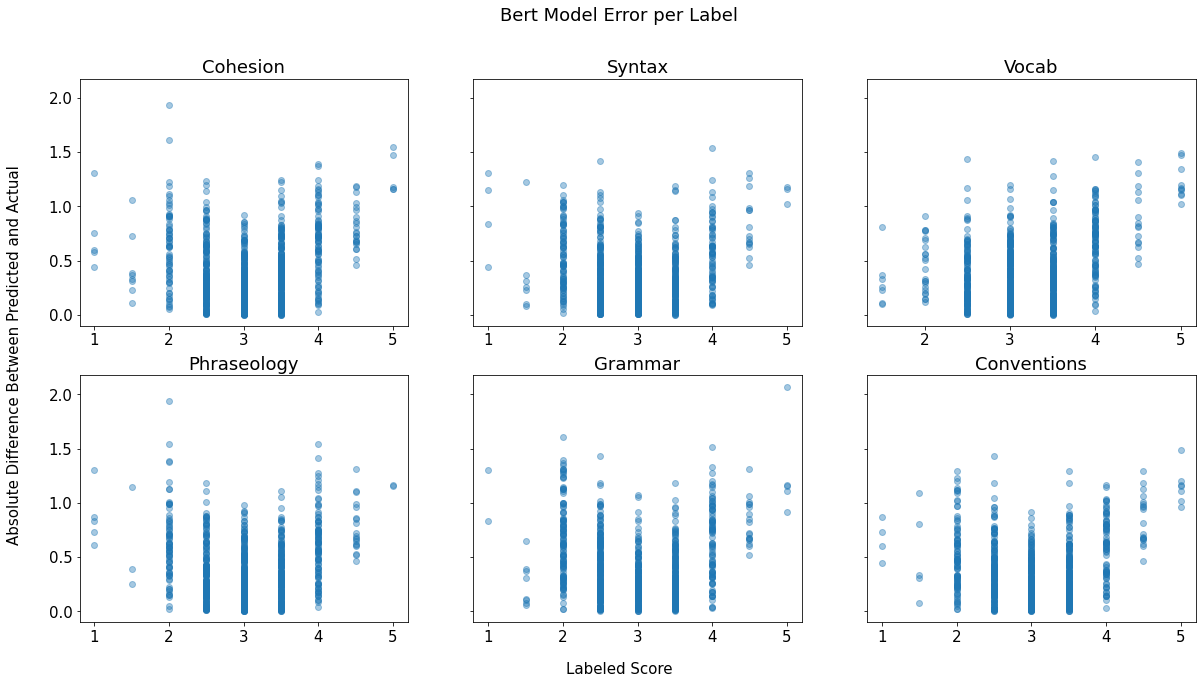

In [36]:
plt.rcParams.update({'font.size': 15})

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharey=True)
fig.suptitle('Bert Model Error per Label')
fig.set_figheight(10)
fig.set_figwidth(20)

#cohesion
ax1.scatter(cohesion_df_bert.actual, cohesion_df_bert.difference, alpha=0.4)
ax1.title.set_text('Cohesion')

#syntax
ax2.scatter(syntax_df_bert.actual, syntax_df_bert.difference, alpha=0.4)
ax2.title.set_text('Syntax')

#vocab
ax3.scatter(vocab_df_bert.actual, vocab_df_bert.difference, alpha=0.4)
ax3.title.set_text('Vocab')

#phraseology
ax4.scatter(phrase_df_bert.actual, phrase_df_bert.difference, alpha=0.4)
ax4.title.set_text('Phraseology')

#grammar
ax5.scatter(grammar_df_bert.actual, grammar_df_bert.difference, alpha=0.4)
ax5.title.set_text('Grammar')

#conventions
ax6.scatter(conv_df_bert.actual, conv_df_bert.difference, alpha=0.4)
ax6.title.set_text('Conventions')


# Set common labels
fig.text(0.5, 0.06, 'Labeled Score', ha='center', va='center')
fig.text(0.08, 0.5, 'Absolute Difference Between Predicted and Actual ', ha='center', va='center', rotation='vertical')

fig.show()
# RUBRIC_COLS = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']


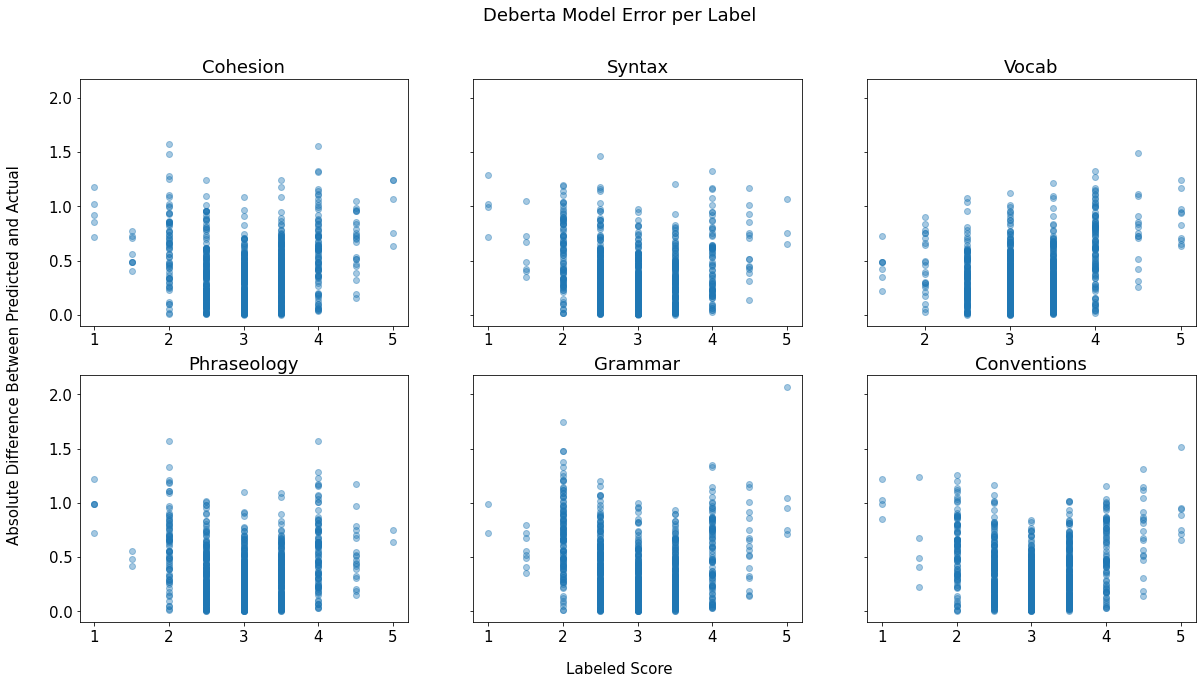

In [37]:
plt.rcParams.update({'font.size': 15})

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharey=True)
fig.suptitle('Deberta Model Error per Label')
fig.set_figheight(10)
fig.set_figwidth(20)

#cohesion
ax1.scatter(cohesion_df_deberta.actual, cohesion_df_deberta.difference, alpha=0.4)
ax1.title.set_text('Cohesion')

#syntax
ax2.scatter(syntax_df_deberta.actual, syntax_df_deberta.difference, alpha=0.4)
ax2.title.set_text('Syntax')

#vocab
ax3.scatter(vocab_df_deberta.actual, vocab_df_deberta.difference, alpha=0.4)
ax3.title.set_text('Vocab')

#phraseology
ax4.scatter(phrase_df_deberta.actual, phrase_df_deberta.difference, alpha=0.4)
ax4.title.set_text('Phraseology')

#grammar
ax5.scatter(grammar_df_deberta.actual, grammar_df_deberta.difference, alpha=0.4)
ax5.title.set_text('Grammar')

#conventions
ax6.scatter(conv_df_deberta.actual, conv_df_deberta.difference, alpha=0.4)
ax6.title.set_text('Conventions')


# Set common labels
fig.text(0.5, 0.06, 'Labeled Score', ha='center', va='center')
fig.text(0.08, 0.5, 'Absolute Difference Between Predicted and Actual ', ha='center', va='center', rotation='vertical')

fig.show()
# RUBRIC_COLS = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']